# $x^2$ potential

In [1]:
import pickle
import numpy as np
import pycuda.gpuarray as gpuarray
from scipy.special import hyp1f1
import scipy.fftpack as fftpack
import pylab as plt
import time

#-------------------------------------------------------------------------------------
from pywignercuda_path import SetPyWignerCUDA_Path
SetPyWignerCUDA_Path()
from GPU_Wigner2D_GPitaevskii import *

In [2]:
%matplotlib inline

## Settings

In [3]:
class frame( GPU_Wigner2D_GPitaevskii_Bloch ):
    def __init__ (self):
        X_gridDIM = 512
        P_gridDIM = 512
        
        X_amplitude  = 16
        P_amplitude  = 16
        
        kappa = 1.
        dt= 0.01
        
        timeSteps =    800
        skipFrames =   100
        
        mass = 1.      
        # Diffusion parameter 
        D_Theta  = 0.0
        D_Lambda = 0.000    
        
        # Damping parameters (implies another source of diffusion as well)
        self.dampingFunction = 'CaldeiraLeggett'
        gammaDamping  = 0.0 #8*10**(-6)
        epsilon       = 0.5;
        
         #Gross Pitaevskii coefficient
        self.GPitaevskiiCoeff = 1.
        
        # Potential and derivative of potential
        self.omega = 1.
        X2_constant = 0.5*mass*self.omega**2
        
        kinematicString  = '0.5*p*p/{mass}'.format(mass=mass)
        potentialString  = '{0}*pow(x,2)'.format(X2_constant)

        dPotentialString = '2*{0}*x'.format(X2_constant)
        
        self.fp_Damping_String = ' p*p/sqrt( p*p + {epsilon}  ) '.format( epsilon=epsilon )
        
        self.SetTimeTrack( dt, timeSteps, skipFrames,
        fileName = '/home/rcabrera/DATA/Wigner2D_GPitaevskii/X2.hdf5' )
        
        GPU_Wigner2D_GPitaevskii_Bloch.__init__(self,
            X_gridDIM,P_gridDIM,X_amplitude,P_amplitude,
            kappa,mass,D_Theta,D_Lambda,gammaDamping,potentialString,dPotentialString,kinematicString)
    
    
    def Set_Initial_Condition(self):
        """
        """
        self.W_init = np.exp( -self.X**2/20. - self.P**2/20.  )
        
        norm =  np.sum(self.W_init)*self.dX*self.dP
        
        self.W_init /= norm

## Run

In [4]:
instance = frame()
print '							'
print ' 	Wigner2D propagator with damping	'
print '							'

instance.Set_Initial_Condition ()

%time instance.Run( )

							
 	Wigner2D propagator with damping	
							
 X_gridDIM =  512    P_gridDIM =  512
 dx =  0.0625  dp =  0.0625
 dLambda =  0.196349540849  dTheta =  0.196349540849
  
         GPU memory Total        5.24945068359 GB
         GPU memory Free         5.03464126587 GB
Initial W Norm =  (1+0j)
         GPU memory Free  post gpu loading  5.01120376587 GB
 ------------------------------------------------------------------------------- 
     Split Operator Propagator  GPU with damping                                 
 ------------------------------------------------------------------------------- 
        
        
 progress  0 %
 progress  12 %
 progress  24 %
 progress  37 %
 progress  49 %
 progress  62 %
 progress  74 %
 progress  87 %
 progress  99 %
CPU times: user 8 s, sys: 5.34 s, total: 13.3 s
Wall time: 14.5 s


0

## Plots

Potential


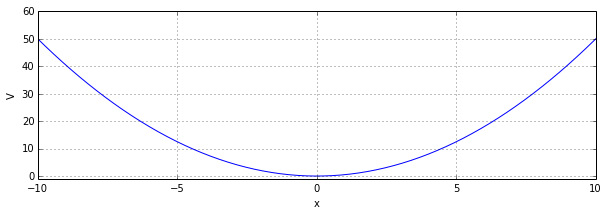

In [5]:
print 'Potential'
fig, ax = plt.subplots(figsize=(10, 3))
ax.plot( instance.X_range,   instance.Potential(0,instance.X_range) )
ax.set_xlim(-10,10)
ax.set_ylim(-1,60)
ax.set_xlabel('x')
ax.set_ylabel('V')
ax.grid('on')

In [6]:
def PlotWignerFrame( W_input , x_plotRange,p_plotRange):
    W = W_input.copy()
    W = fftpack.fftshift(W.real)    
    
    dp    = instance.dP
    p_min = -instance.P_amplitude
    p_max =  instance.P_amplitude - dp   
    
    #p_min = -dp*instance.P_gridDIM/2.
    #p_max =  dp*instance.P_gridDIM/2. - dp    
    
    x_min = -instance.X_amplitude
    x_max =  instance.X_amplitude - instance.dX
    
    global_max = 0.17          #  Maximum value used to select the color range
    global_min = -0.31         # 
        
    print 'min = ', np.min( W ), ' max = ', np.max( W )
    print 'final time =', instance.timeRange[-1] ,'a.u.  =',\
    instance.timeRange[-1]*( 2.418884326505*10.**(-17) ) , ' s '
    
    print 'normalization = ', np.sum( W )*instance.dX*dp

    zero_position =  abs( global_min) / (abs( global_max) + abs(global_min)) 
    wigner_cdict = {'red' 	: 	((0., 0., 0.),
							(zero_position, 1., 1.), 
							(1., 1., 1.)),
					'green' :	((0., 0., 0.),
							(zero_position, 1., 1.),
							(1., 0., 0.)),
					'blue'	:	((0., 1., 1.),
							(zero_position, 1., 1.),
							(1., 0., 0.)) }
    wigner_cmap = matplotlib.colors.LinearSegmentedColormap('wigner_colormap', wigner_cdict, 256)

    fig, ax = plt.subplots(figsize=(12, 5))

    cax = ax.imshow( W ,origin='lower',interpolation='none',\
    extent=[ x_min , x_max, p_min, p_max], vmin= global_min, vmax=global_max, cmap=wigner_cmap)

    ax.contour(instance.Hamiltonian ,
                np.arange(0, 10, 1 ),origin='lower',extent=[x_min,x_max,p_min,p_max],
               linewidths=0.25,colors='k')
    
    axis_font = {'size':'24'}
    
    ax.set_xlabel(r'$x$',**axis_font)
    ax.set_ylabel(r'$p$',**axis_font)
    
    ax.set_xlim((x_plotRange[0] , x_plotRange[1] ))
    ax.set_ylim((p_plotRange[0] , p_plotRange[1] ))
    ax.set_aspect(1.)
    #ax.grid('on')
    cbar = fig.colorbar(cax, ticks=[-0.3, -0.2,-0.1, 0, 0.1, 0.2 , 0.3])
    matplotlib.rcParams.update({'font.size': 18})
    return fig

min =  1.21305854123e-13  max =  0.015915507691
final time = 8.0 a.u.  = 1.9351074612e-16  s 
normalization =  1.0


/usr/lib/pymodules/python2.7/matplotlib/collections.py:608: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != 'face':
/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


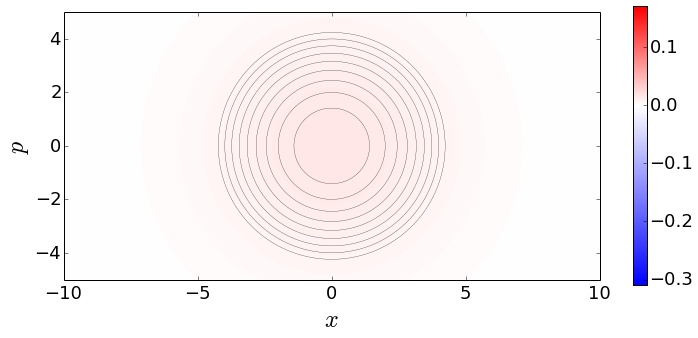

In [7]:
plot_init = PlotWignerFrame( instance.W_init.real , (-10.,10) ,(-5,5)  )


In [8]:
np.sum( instance.W_end  )* instance.dX*instance.dP

0.99999999999999989

min =  -0.000683046801767  max =  0.317703452498
final time = 8.0 a.u.  = 1.9351074612e-16  s 
normalization =  1.0


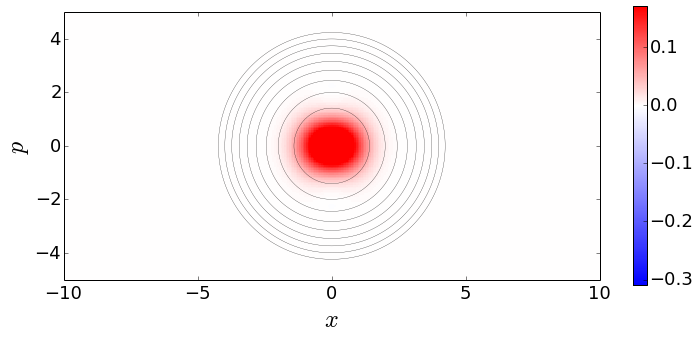

In [9]:
plot_init = PlotWignerFrame( instance.W_end , (-10.,10) ,(-5,5)  )

In [10]:
def PlotMarginals():
    
    W = fftpack.fftshift( instance.W_end )
    
    dp    = instance.dP
    p_min = -instance.P_amplitude
    p_max =  instance.P_amplitude - dp   
        
    W0 = fftpack.fftshift(instance.W_init  )
    
    marginal_x_init = np.sum(  W0 , axis=0 )*dp
    marginal_p_init = np.sum(  W0 , axis=1 )*instance.dX

    marginal_x = np.sum(  W, axis=0 )*dp
    marginal_p = np.sum(  W, axis=1 )*instance.dX


    x_min = -instance.X_amplitude
    x_max = instance.X_amplitude - instance.dX 
    #.......................................... Marginal in position

    plt.figure(figsize=(10,10))
    plt.subplot(211)

    plt.plot(instance.X_range, marginal_x_init, '-',label='initial')
    plt.plot(instance.X_range, marginal_x,  label='final')
    #plt.axis([x_min, 0*x_max, -0.01,6])
    plt.xlabel('x')
    plt.ylabel('Prob')

    plt.legend(loc='upper right', shadow=True)

    #..........................................  Marginal in momentum

    print 'p = ', np.sum( marginal_p*instance.P_range )*dp,\
    '->', np.sum( W*instance.P )*instance.dX*dp
    print 'x = ', np.sum( W0*instance.X )*instance.dX*dp, \
    '->',np.sum( W*instance.X )*instance.dX*dp
    
    rangeP = np.linspace( p_min, p_max, instance.P_gridDIM )
    
    plt.subplot(212)
    plt.plot(rangeP, marginal_p_init ,'-', label='initial')
    plt.plot(rangeP, marginal_p  , label='final')
    plt.axis([p_min, p_max, -0.01, 1])
    plt.xlabel('p')
    plt.ylabel('Prob')

    plt.legend(loc='upper right', shadow=True)

p =  -1.05471187339e-14 -> -0.608178395598
x =  -0.126156679138 -> -0.502753310047


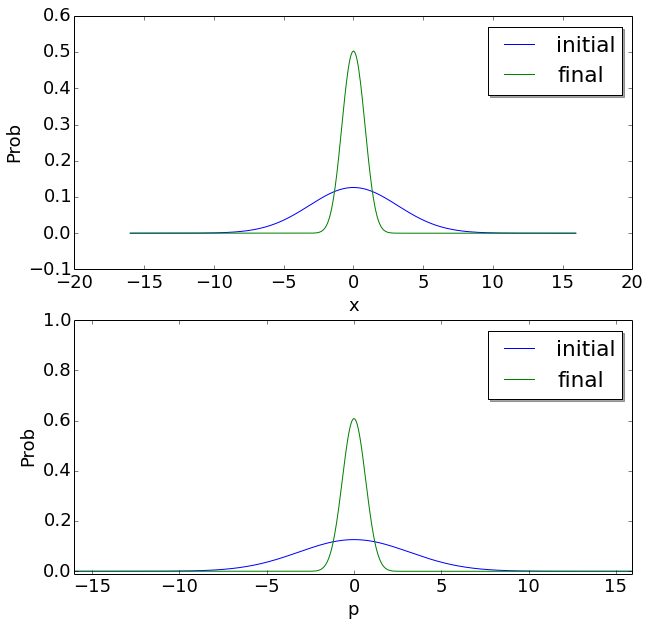

In [11]:
PlotMarginals()

## First Order Ehrenfest

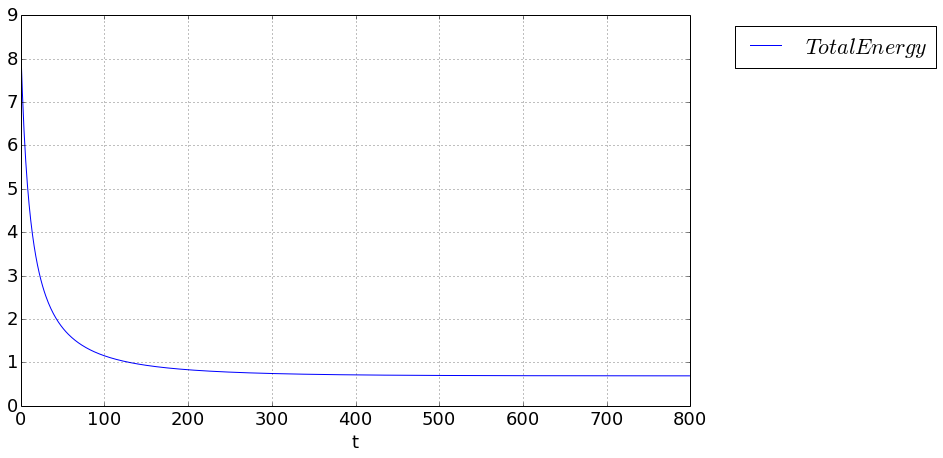

In [12]:
fig, ax = plt.subplots(figsize=(12, 7))

ax.plot( instance.TotalEnergyHistory  ,
        '-' , label = '$Total Energy$' , linewidth=1.)



ax.legend(bbox_to_anchor=(1.05, 1), loc=2, prop={'size':22})
#ax.set_ylim( 1.15 , 1.25)
ax.set_xlabel('t')
ax.set_ylabel(' ')
ax.grid();

In [13]:
instance.NonLinearEnergyHistory.shape

(800,)

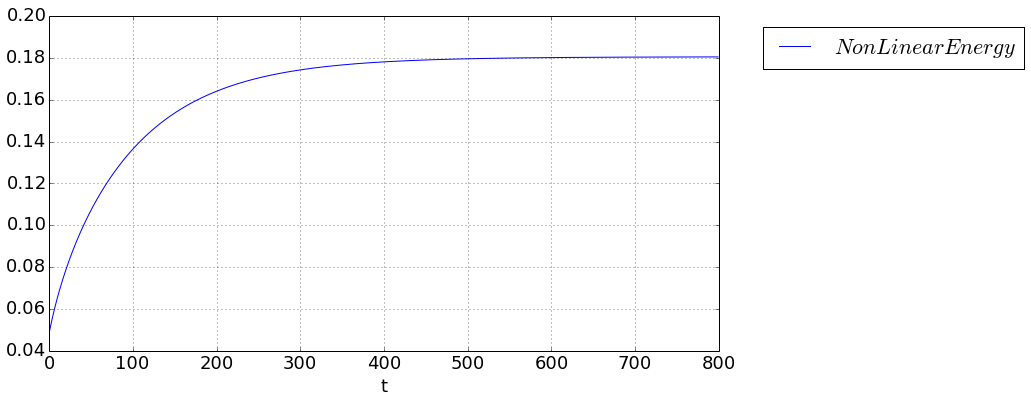

In [14]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(  instance.NonLinearEnergyHistory
        , '-' , label = '$Non Linear Energy$' , linewidth=1.)


ax.legend(bbox_to_anchor=(1.05, 1), loc=2, prop={'size':22})
#ax.set_ylim( 1.19 , 1.21 )
ax.set_xlabel('t')
ax.set_ylabel(' ')
ax.grid();

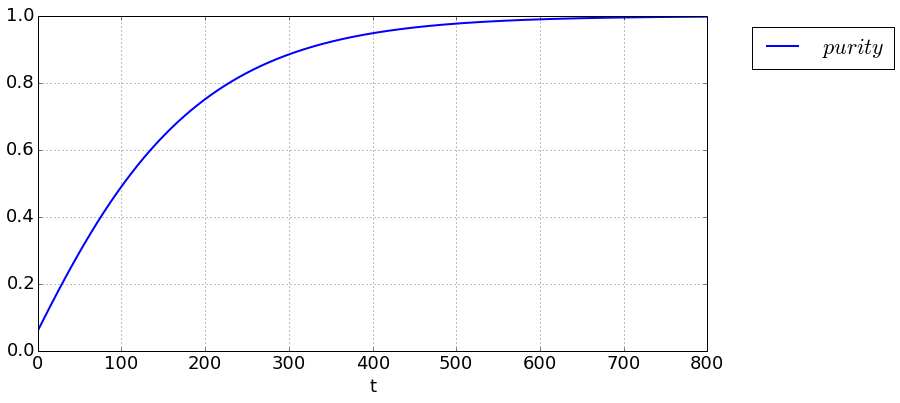

In [15]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(  instance.purity , '-' , label = '$purity $',linewidth=2.)


ax.legend(bbox_to_anchor=(1.05, 1), loc=2, prop={'size':22})
#ax.set_ylim( 0.99 , 1.01 )
ax.set_xlabel('t')
ax.set_ylabel(' ')
ax.grid();

In [16]:
baseDir = '/home/rcabrera/Documents/source/python/PyWignerCUDA/instances/Wigner2D_GPitaevskii/'

CPU_file = baseDir+'DATA_CPU_Wigner2D_GP.hdf5'

CPU_FILE = h5py.File( CPU_file ,'r')

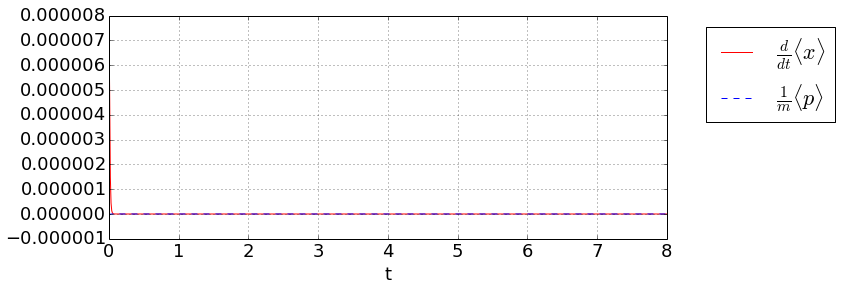

In [17]:
fig, ax = plt.subplots(figsize=(10, 4))

ax.plot( instance.timeRange ,  np.gradient(instance.X_average, instance.dt) , '-',
        label = '$\\frac{d}{dt} \\langle x \\rangle $' ,color = 'red', linewidth=1.)

ax.plot( instance.timeRange ,  instance.P_average/instance.mass , '--' ,
        label='$\\frac{1}{m}\\langle p \\rangle$', linewidth=1. )


#ax.set_xlim(0,3.5)
#ax.set_ylim(-1.,1.2)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, prop={'size':22})
ax.set_xlabel('t')
ax.grid();

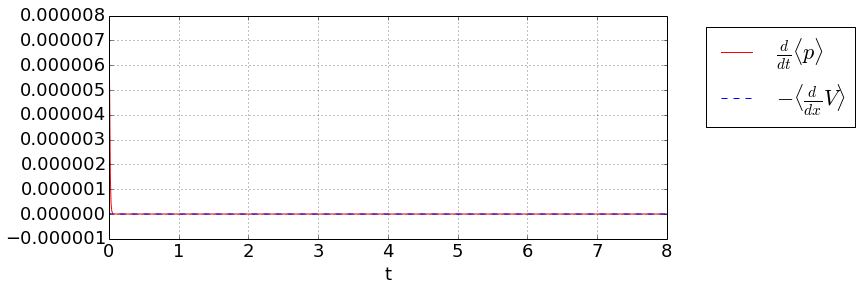

In [18]:
fig, ax = plt.subplots(figsize=(10, 4))

ax.plot( instance.timeRange ,  np.gradient( instance.P_average , instance.dt) ,'-' , 
        label =  '$\\frac{d}{dt} \\langle p \\rangle $' ,color = 'r' , linewidth=1.)

ax.plot( instance.timeRange , 
        - instance.dPotentialdX_average    , '--' ,
        label = '$ -\\langle \\frac{d}{dx}V  \\rangle $' ,linewidth=1.)


ax.legend(bbox_to_anchor=(1.05, 1), loc=2, prop={'size':22})
#ax.set_ylim(-0.8,0.8)
ax.set_xlabel('t')
#ax.set_ylabel(' ')
ax.grid();

### Second Order Ehrenfest Theorems

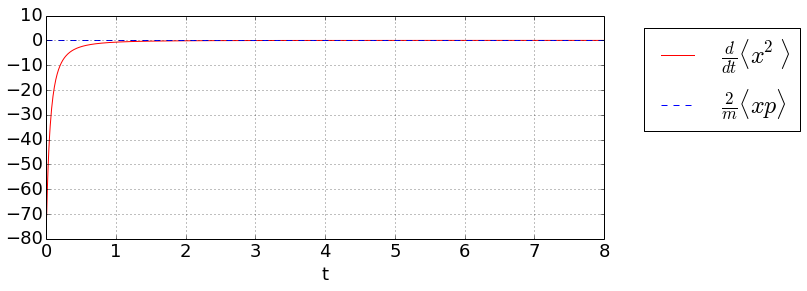

In [19]:
fig, ax = plt.subplots(figsize=(10, 4))

ax.plot( instance.timeRange , np.gradient( instance.X2_average , instance.dt) , '-',
        label='$\\frac{d}{dt}  \\langle x^2  \\rangle$' , color = 'red', linewidth=1.)

ax.plot( instance.timeRange , \
        2*instance.XP_average/instance.mass, '--',label = '$\\frac{2}{m}  \\langle xp  \\rangle$',linewidth=1. )


#ax.set_xlim(0,3.5)
#ax.set_ylim(-1.,1.2)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, prop={'size':24})
ax.set_xlabel('t')
ax.grid();

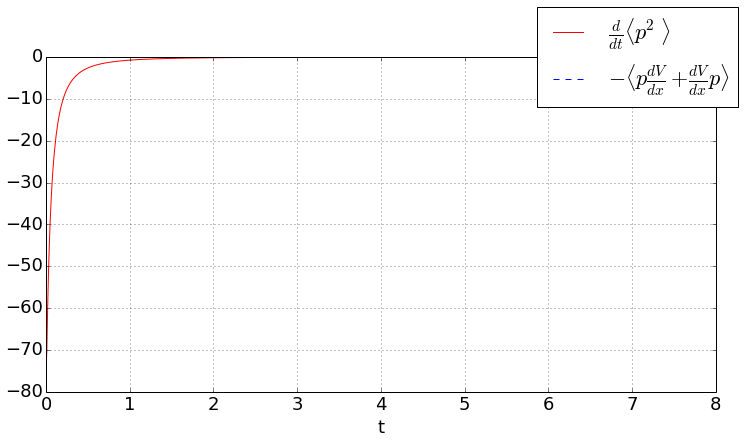

In [20]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot( instance.timeRange , np.gradient( instance.P2_average , instance.dt)  , '-',
        label = '$\\frac{d}{dt}  \\langle p^2  \\rangle$',
        color = 'red', linewidth=1.)

ax.plot( instance.timeRange , \
        -2*instance.PdPotentialdX_average
        , '--',
        label = '$-  \\langle p\\frac{dV}{dx} +\\frac{dV}{dx} p \\rangle  $',
        linewidth=1. )



#ax.set_xlim(-0.2,26)
#ax.set_ylim(-1.,1.2)
ax.legend(bbox_to_anchor=(1.05, 1), loc=5, prop={'size':22})
ax.set_xlabel('t')
ax.grid();

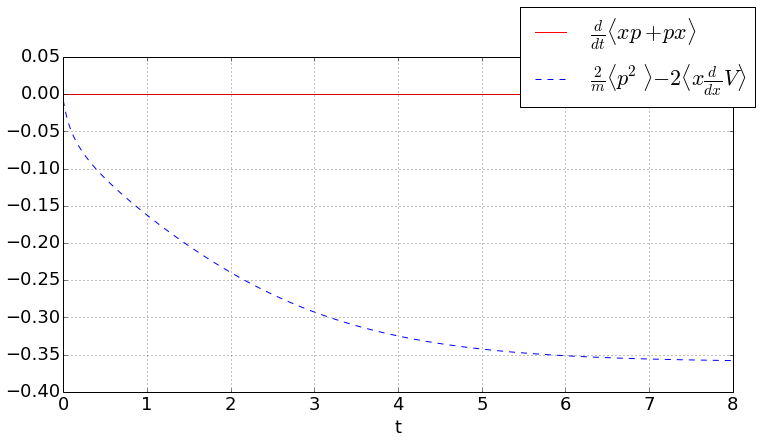

In [21]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot( instance.timeRange ,  2*np.gradient( instance.XP_average , instance.dt) ,
        '-' ,label = '$\\frac{d}{dt} \\langle xp+px  \\rangle$' , color = 'r' , linewidth=1. )

ax.plot( instance.timeRange , \
          2*instance.P2_average/instance.mass  \
         -2*instance.XdPotentialdX_average   
         , '--' , 
         label = '$\\frac{2}{m}  \\langle p^2  \\rangle - 2  \\langle x \\frac{d}{dx}V  \\rangle   $'
        ,linewidth=1.)


ax.legend(bbox_to_anchor=(1.05, 1), loc=5, prop={'size':22})
#ax.set_ylim(- 12 , 7)
ax.set_xlabel('t')
ax.set_ylabel(' ')
ax.grid();

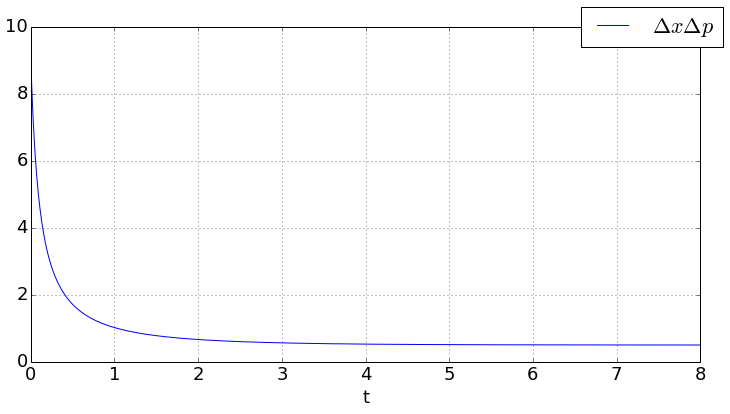

In [22]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot( instance.timeRange ,
np.sqrt(instance.X2_average - instance.X_average**2)*np.sqrt(instance.P2_average - instance.P_average**2)
        , '-' , label = '$\\Delta x \\Delta p$' , linewidth=1.)


ax.legend(bbox_to_anchor=(1.05, 1), loc=5, prop={'size':22})
#ax.set_ylim(-50, 0)
ax.set_xlabel('t')
#ax.set_xlim(0,41000)
ax.set_ylabel(' ')
ax.grid();


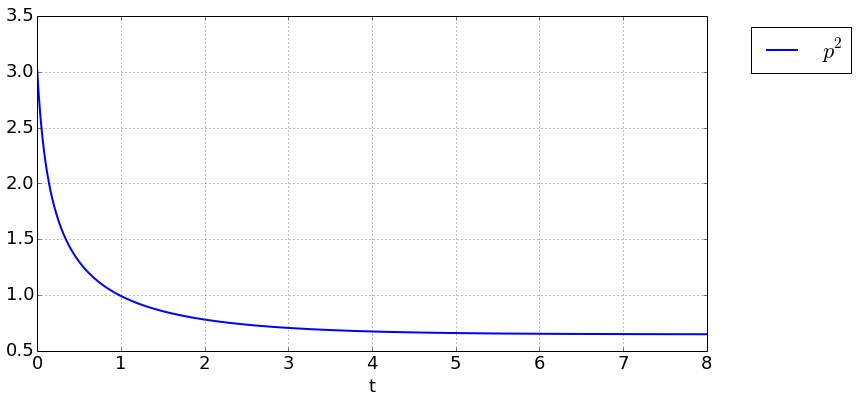

In [23]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot( instance.timeRange , \
          np.sqrt(instance.P2_average - instance.P_average**2) \
         , '-' , label = '$p^2 $',linewidth=2.)

#ax.plot( instance.timeRange , instance.X3_average - 2*gamma*instance.P_average , '-' ,
#        label = '$-F-2\gamma <P>$' ,linewidth=2.)

ax.legend(bbox_to_anchor=(1.05, 1), loc=2, prop={'size':22})
#ax.set_ylim(- 12 , 7)
ax.set_xlabel('t')
ax.set_ylabel(' ')
ax.grid();

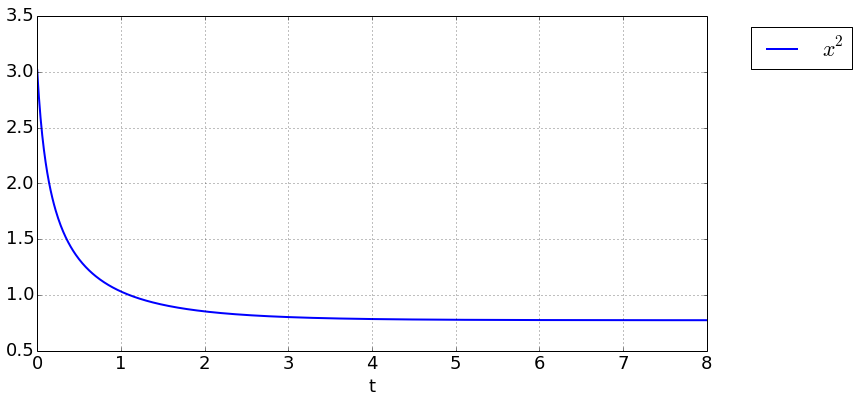

In [24]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot( instance.timeRange , \
          np.sqrt(instance.X2_average - instance.X_average**2) \
         , '-' , label = '$x^2 $',linewidth=2.)

#ax.plot( instance.timeRange , instance.X3_average - 2*gamma*instance.P_average , '-' ,
#        label = '$-F-2\gamma <P>$' ,linewidth=2.)

ax.legend(bbox_to_anchor=(1.05, 1), loc=2, prop={'size':22})
#ax.set_ylim(- 12 , 7)
ax.set_xlabel('t')
ax.set_ylabel(' ')
ax.grid();